## Import 

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import geocoder

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20200430132957-0001
KERNEL_ID = 5d74505b-9279-4dd4-b0bd-21e158e22802


## First, we're going to download the NY dataset

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [5]:
#newyork_data

We only want the feature key information

In [6]:
neighborhoods_data = newyork_data['features']

In [7]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
NY_neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    NY_neighborhoods = NY_neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [8]:
NY_neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [9]:
NY_neighborhoods.shape

(306, 4)

## Let's analyse Japanese restaurant for each neighborhood of NY

### Credentials

In [10]:
CLIENT_ID = 'LM2L4D5Z4ATYHUCOTUA5TC3R0Q5PUT3N2YGELGYTS4KMDZDJ' # your Foursquare ID
CLIENT_SECRET = 'K40PSAKDDYP5FVBJY0XAIQG0M5OZXDZI0Y24EHNMTWKMSGUF' # your Foursquare Secret
VERSION = '20203004' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: LM2L4D5Z4ATYHUCOTUA5TC3R0Q5PUT3N2YGELGYTS4KMDZDJ
CLIENT_SECRET:K40PSAKDDYP5FVBJY0XAIQG0M5OZXDZI0Y24EHNMTWKMSGUF


### Get venues equal to 'Japanese Restaurant'

Define function to get venues

In [11]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100

    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [64]:
japanese_restaurant_df=pd.DataFrame(columns=['Borough', 'Neighborhood', 'ID','Name'])
count=1
for row in NY_neighborhoods.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    japanese_restaurant=venues[venues['Category']=='Japanese Restaurant']   
    #print('(',count,'/',len(NY_neighborhoods),')','Japanese Resturants in '+Neighborhood+', '+Borough+':'+str(len(japanese_restaurant)))
    for resturant_detail in japanese_restaurant.values.tolist():
        id, name , category=resturant_detail
        japanese_restaurant_df = japanese_restaurant_df.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

In [14]:
japanese_restaurant_df.shape

(183, 4)

#### There is 183 japanese restaurants in New York.

In [15]:
japanese_restaurant_df.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Riverdale,503cfaffe4b066d39de5005a,Aoyu Japanese Restaurant
1,Bronx,Riverdale,4b0b311af964a520642e23e3,Palace of Japan
2,Bronx,Kingsbridge,503cfaffe4b066d39de5005a,Aoyu Japanese Restaurant
3,Bronx,Kingsbridge,4b0b311af964a520642e23e3,Palace of Japan
4,Bronx,City Island,4dbdf3d790a02849cbd675be,Ohana Japanese Habachi Seafood & Steakhouse


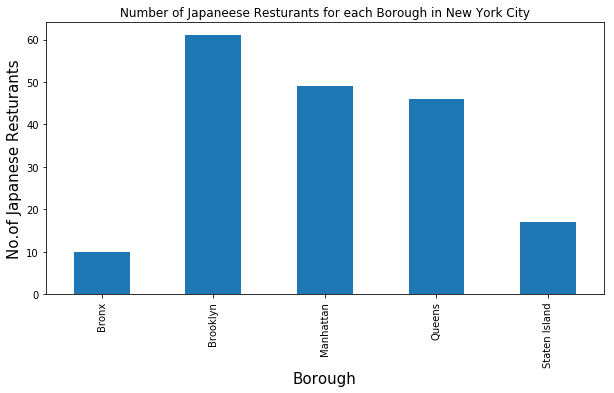

In [75]:
plt.figure(figsize=(10,5))
plt.title('Number of Japaneese Resturants for each Borough in New York City')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Japanese Resturants', fontsize=15)
japanese_restaurant_df.groupby('Borough')['ID'].count().plot(kind='bar')
plt.show()

#### The borough with the most of Japanese Restaurant is the Bronx

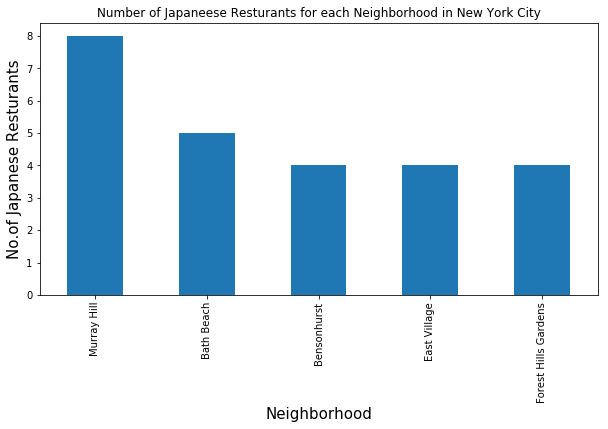

In [17]:
plt.figure(figsize=(10,5))
plt.title('Number of Japaneese Resturants for each Neighborhood in New York City')
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No.of Japanese Resturants', fontsize=15)
japanese_restaurant_df.groupby('Neighborhood')['Borough'].count().nlargest(5).plot(kind='bar')
plt.show()

#### The neighborhood with the most of  japanese restaurants seems to be Murray Hill

In [18]:
japanese_restaurant_df[japanese_restaurant_df['Neighborhood']=='Murray Hill']

,Borough,Neighborhood,ID,Name
77,Manhattan,Murray Hill,4a99b4f4f964a520f62f20e3,Kajitsu
78,Manhattan,Murray Hill,540dc46d498e86f0e5059dd2,Zuma New York
79,Manhattan,Murray Hill,591caee89deb7d0f69be77a2,Omusubi Gonbei
80,Manhattan,Murray Hill,48c50c4bf964a520dc511fe3,Café Zaiya
81,Manhattan,Murray Hill,49db8b67f964a520d85e1fe3,Aburiya Kinnosuke
82,Manhattan,Murray Hill,51e8ce40498ea1fb0180efb2,Izakaya MEW
116,Queens,Murray Hill,4bc8eee83740b713fcbe5d65,Northern Sushi
117,Queens,Murray Hill,5cf07afa66f3cd002c8b3ae6,Izakaya Mew


#### But in fact here we can see that there is two neighborhood with the same name but from different borough, so let's pre-process our data to overcome this problem.

We rename 'Murray Hill' from 'Queens' borough 'Murray Hill, Queens' in the 'Neighborhood column.

In [63]:
japanese_restaurant_df.loc[(japanese_restaurant_df.Borough == 'Queens')&(japanese_restaurant_df.Neighborhood == 'Murray Hill'),'Neighborhood'] = "Murray Hill, Queens"

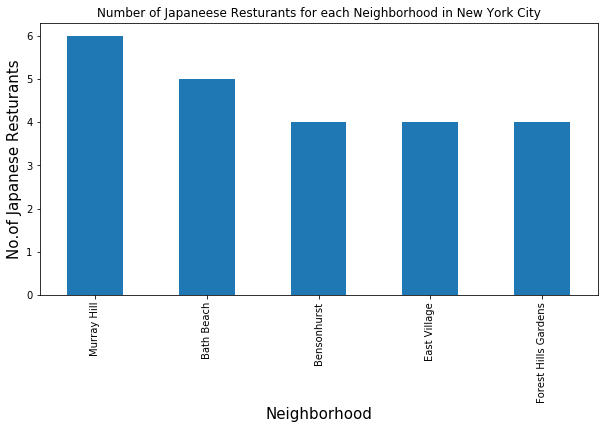

In [20]:
plt.figure(figsize=(10,5))
plt.title('Number of Japaneese Resturants for each Neighborhood in New York City')
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No.of Japanese Resturants', fontsize=15)
japanese_restaurant_df.groupby('Neighborhood')['Borough'].count().nlargest(5).plot(kind='bar')
plt.show()

In [21]:
japanese_restaurant_df[(japanese_restaurant_df['Neighborhood']=='Murray Hill') | (japanese_restaurant_df['Neighborhood']=='Bath Beach')]

,Borough,Neighborhood,ID,Name
36,Brooklyn,Bath Beach,51f42bb3498e2681264e00a1,Kasumi Sushi & BBQ Restaurant
37,Brooklyn,Bath Beach,4b787863f964a52080d02ee3,Shiki Japanese Hibachi
38,Brooklyn,Bath Beach,4c326b9fa0ced13ac126156e,Ichi Sushi
39,Brooklyn,Bath Beach,513e7ec8e4b07f4fa1b53b3d,Fuki Sushi Japanese Restaurant
40,Brooklyn,Bath Beach,4bad45c9f964a52089403be3,Chikurin
77,Manhattan,Murray Hill,4a99b4f4f964a520f62f20e3,Kajitsu
78,Manhattan,Murray Hill,540dc46d498e86f0e5059dd2,Zuma New York
79,Manhattan,Murray Hill,591caee89deb7d0f69be77a2,Omusubi Gonbei
80,Manhattan,Murray Hill,48c50c4bf964a520dc511fe3,Café Zaiya
81,Manhattan,Murray Hill,49db8b67f964a520d85e1fe3,Aburiya Kinnosuke


#### The neighborhood with the most of japanese restaurant is indeed Murray Hill in Manhattan. The second one is Bath Beach located in Brooklyn which is the borough with the most of japaneese restaurant.

Let's define a function to get venues details like tips or ratings.

In [22]:
def get_venue_details(venue_id):
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [62]:
jap_rates=pd.DataFrame(columns=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips'])
count=1


for row in japanese_restaurant_df.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        id,name,likes,rating,tips=[0]*5
    #print('(',count,'/',len(japanese_restaurant_df),')','processed')
    jap_rates = jap_rates.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

In [25]:
jap_rates.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Riverdale,503cfaffe4b066d39de5005a,Aoyu Japanese Restaurant,32,8.8,19
1,Bronx,Riverdale,4b0b311af964a520642e23e3,Palace of Japan,38,8.6,26
2,Bronx,Kingsbridge,503cfaffe4b066d39de5005a,Aoyu Japanese Restaurant,32,8.8,19
3,Bronx,Kingsbridge,4b0b311af964a520642e23e3,Palace of Japan,38,8.6,26
4,Bronx,City Island,4dbdf3d790a02849cbd675be,Ohana Japanese Habachi Seafood & Steakhouse,34,7.4,18


In [26]:
jap_rates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183 entries, 0 to 182
Data columns (total 7 columns):
Borough         183 non-null object
Neighborhood    183 non-null object
ID              183 non-null object
Name            183 non-null object
Likes           183 non-null object
Rating          183 non-null float64
Tips            183 non-null object
dtypes: float64(1), object(6)
memory usage: 10.1+ KB


In [30]:
jap_rates['Likes']=jap_rates['Likes'].astype('float64')
jap_rates['Tips']=jap_rates['Tips'].astype('float64')
jap_rates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183 entries, 0 to 182
Data columns (total 7 columns):
Borough         183 non-null object
Neighborhood    183 non-null object
ID              183 non-null object
Name            183 non-null object
Likes           183 non-null float64
Rating          183 non-null float64
Tips            183 non-null float64
dtypes: float64(3), object(4)
memory usage: 10.1+ KB


In [33]:
jap_rates.iloc[jap_rates['Likes'].idxmax()]


Borough                        Manhattan
Neighborhood                     Midtown
ID              51e8ce40498ea1fb0180efb2
Name                         Izakaya MEW
Likes                               1055
Rating                               8.8
Tips                                 266
Name: 76, dtype: object

#### The restaurant with maximum likes is Izakaya MEW, in Midtown,Manhattan.

In [35]:
jap_rates.iloc[jap_rates['Rating'].idxmax()]


Borough                         Brooklyn
Neighborhood           East Williamsburg
ID              52517e05498ec2e28c792fa2
Name               Brooklyn Ball Factory
Likes                                298
Rating                               9.3
Tips                                  89
Name: 55, dtype: object

#### The restaurant with top rating is Brooklynn Ball Factory, in East Williamsburg,Brooklyn.

In [36]:
jap_rates.iloc[jap_rates['Tips'].idxmax()]


Borough                        Manhattan
Neighborhood                     Midtown
ID              51e8ce40498ea1fb0180efb2
Name                         Izakaya MEW
Likes                               1055
Rating                               8.8
Tips                                 266
Name: 76, dtype: object

#### The restaurant with maximum tips is Izakaya MEW, in Midtown,Manhattan.

In [43]:
bests_neighborhoods=jap_rates.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
bests_neighborhoods.columns=['Neighborhood','Average Rating']

In [44]:
bests_neighborhoods.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
66,Lower East Side,9.200000
79,Noho,9.175000
28,East Village,9.125000
19,Cobble Hill,9.100000
33,Flatiron,9.033333
98,Stuyvesant Town,9.000000
48,Greenwich Village,9.000000
29,East Williamsburg,9.000000
43,Gramercy,8.900000
80,North Side,8.900000


In [45]:
bests_borough=jap_rates.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
bests_borough.columns=['Borough','Average Rating']

In [48]:
bests_borough.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.646939
1,Brooklyn,7.672131
0,Bronx,7.500000
3,Queens,7.195652
4,Staten Island,5.941176


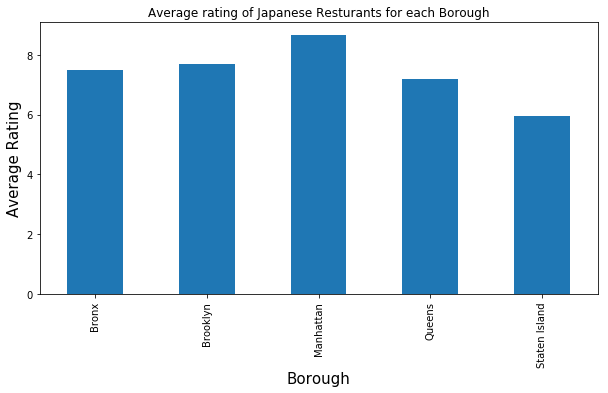

In [74]:
plt.figure(figsize=(10,5))
plt.title('Average rating of Japanese Resturants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
jap_rates.groupby('Borough').mean()['Rating'].plot(kind='bar')
plt.show()

#### Manhattan is the borough with the best ratings for japanese restaurant.

In [51]:
bests_neighborhoods=bests_neighborhoods[bests_neighborhoods['Average Rating']>=9.0]
bests_neighborhoods

,Neighborhood,Average Rating
19,Cobble Hill,9.100000
28,East Village,9.125000
29,East Williamsburg,9.000000
33,Flatiron,9.033333
48,Greenwich Village,9.000000
66,Lower East Side,9.200000
79,Noho,9.175000
98,Stuyvesant Town,9.000000


### Let's visualize this in a map

In [60]:
bests_neighborhoods=pd.merge(bests_neighborhoods,NY_neighborhoods, on='Neighborhood')
bests_neighborhoods1=bests_neighborhoods[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
bests_neighborhoods1

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Cobble Hill,40.687920,-73.998561,9.100000
1,Manhattan,East Village,40.727847,-73.982226,9.125000
2,Brooklyn,East Williamsburg,40.708492,-73.938858,9.000000
3,Manhattan,Flatiron,40.739673,-73.990947,9.033333
4,Manhattan,Greenwich Village,40.726933,-73.999914,9.000000
5,Manhattan,Lower East Side,40.717807,-73.980890,9.200000
6,Manhattan,Noho,40.723259,-73.988434,9.175000
7,Manhattan,Stuyvesant Town,40.731000,-73.974052,9.000000


In [61]:
bests_neighborhoods1.sort_values(['Average Rating'],ascending=False)

,Borough,Neighborhood,Latitude,Longitude,Average Rating
5,Manhattan,Lower East Side,40.717807,-73.980890,9.200000
6,Manhattan,Noho,40.723259,-73.988434,9.175000
1,Manhattan,East Village,40.727847,-73.982226,9.125000
0,Brooklyn,Cobble Hill,40.687920,-73.998561,9.100000
3,Manhattan,Flatiron,40.739673,-73.990947,9.033333
2,Brooklyn,East Williamsburg,40.708492,-73.938858,9.000000
4,Manhattan,Greenwich Village,40.726933,-73.999914,9.000000
7,Manhattan,Stuyvesant Town,40.731000,-73.974052,9.000000


In [67]:
address = 'New York , NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York are {}, {}.'.format(latitude, longitude))


The geograpical coordinate of New York are 40.7127281, -74.0060152.


In [73]:
ny_map = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood,avg_ratings in zip(bests_neighborhoods1['Latitude'], bests_neighborhoods1['Longitude'], bests_neighborhoods1['Borough'], bests_neighborhoods1['Neighborhood'],bests_neighborhoods1['Average Rating']):
    label = '{}, {}, {}'.format(neighborhood, borough,avg_ratings)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(ny_map)  
    
ny_map